Nama: Putri Fatiha Nuzula

NIM: 2602193042

Kelas: LE09


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gzip
import os
import shutil
from tensorflow.keras import layers, models, Input, callbacks, metrics
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from skimage.metrics import structural_similarity as ssim

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

In [ ]:
!unzip /content/datasetUAS.zip -d /content

Archive:  /content/datasetUAS.zip
replace /content/t10k-images-idx3-ubyte.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/t10k-images-idx3-ubyte.gz  
 extracting: /content/t10k-labels-idx1-ubyte.gz  
  inflating: /content/train-images-idx3-ubyte.gz  
  inflating: /content/train-labels-idx1-ubyte.gz  


### 1.a

In [ ]:
for filename in os.listdir('.'):
  if filename.endswith('.gz'):
     with gzip.open(filename, 'rb') as f_in:
       with open(filename[:-3], 'wb') as f_out:
         shutil.copyfileobj(f_in, f_out)

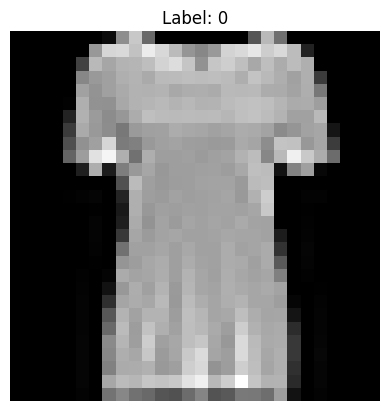

In [ ]:
def read_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype='>u4')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def read_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype='>u4')
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def display_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

#path ke dataset
train_labels_path = 'train-labels-idx1-ubyte.gz'
train_images_path = 'train-images-idx3-ubyte.gz'
test_labels_path = 't10k-labels-idx1-ubyte.gz'
test_images_path = 't10k-images-idx3-ubyte.gz'

#read dataset
train_labels = read_labels(train_labels_path)
train_images = read_images(train_images_path)
test_labels = read_labels(test_labels_path)
test_images = read_images(test_images_path)

#display sample dari data training
display_image(train_images[10], train_labels[10])


In [ ]:
#memberikan label pada setiap class pakaian
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

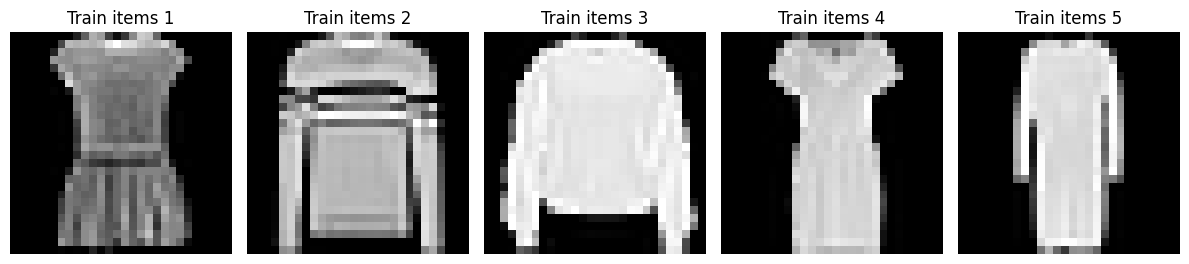

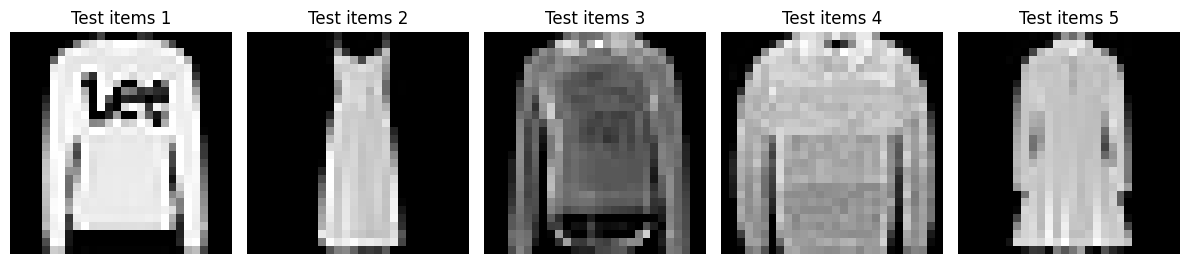

In [ ]:
#filter hanya untuk 'Pullover' dan 'Dress'
items = ([key for key, value in labels.items() if value == "Pullover"])
items.append([key for key, value in labels.items() if value == "Dress"][0])

x_train_items = train_images[np.isin(train_labels, items)]
x_test_items = test_images[np.isin(test_labels, items)]
y_train_items = train_labels[np.isin(train_labels, items)]
y_test_items = test_labels[np.isin(test_labels, items)]

#display train dan test data yang akan digunakan setelah filter
def display_images_in_grid(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

num_images_to_display = 5
display_images_in_grid(x_train_items[:num_images_to_display],
                       [f'Train items {i+1}' for i in range(num_images_to_display)],
                       1, num_images_to_display)

display_images_in_grid(x_test_items[:num_images_to_display],
                       [f'Test items {i+1}' for i in range(num_images_to_display)],
                       1, num_images_to_display)



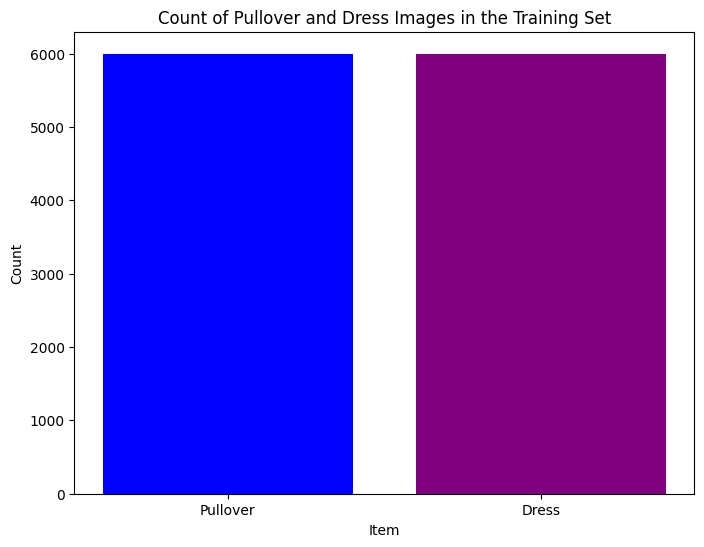

In [ ]:
pullover_count = np.sum(train_labels == items[0])
dress_count = np.sum(train_labels == items[1])

#plot untuk melihat distribusi dari masing-masing kelas
plt.figure(figsize=(8, 6))
plt.bar(['Pullover', 'Dress'], [pullover_count, dress_count], color=['blue', 'purple'])
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('Count of Pullover and Dress Images in the Training Set')
plt.show()

In [ ]:
#normalisasi data
x_train_items = x_train_items / 255.0
x_test_items = x_test_items / 255.0

#reshape agar data dapat digunakan dengan model lstm
x_train_items = np.reshape(x_train_items, (len(x_train_items), 28, 28, 1))
x_test_items = np.reshape(x_test_items, (len(x_test_items), 28, 28, 1))

#menggabungkan data train dan test agar dapat displit kembali
images = np.concatenate((x_train_items, x_test_items), axis=0)
labels = np.concatenate((y_train_items, y_test_items), axis=0)

#data spliting
x_train, x_remaining, y_train, y_remaining = train_test_split(images, labels, test_size=0.2, random_state=42)

#split testing dan validation 10%
x_val, x_test, y_val, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5, random_state=42)

# Print the shapes to verify
print(f"Training set:   {x_train.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set:       {x_test.shape}")


Training set:   (11200, 28, 28, 1)
Validation set: (1400, 28, 28, 1)
Test set:       (1400, 28, 28, 1)


### 1.b

In [ ]:
from tensorflow.keras import layers, models, Input

#base model encoder
input_layer = Input(shape=(28, 28, 1)) #-> 784
encode = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
encode = layers.MaxPooling2D((2, 2), padding='same')(encode)
encode = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encode)
encode = layers.MaxPooling2D((2, 2), padding='same')(encode)
encode = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encode)
encode = layers.Flatten()(encode)
encoder_output = layers.Dense(128, activation='relu')(encode)  #reduksi latent menjadi 128 layer
encoder = models.Model(input_layer, encoder_output, name="encoder")


#base model decoder
decoder_input = layers.Input(shape=(128,))
decode = layers.Dense(7 * 7 * 128, activation='relu')(decoder_input)
decode = layers.Reshape((7, 7, 128))(decode)
decode = layers.UpSampling2D((2, 2))(decode)
decode = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decode)
decode = layers.UpSampling2D((2, 2))(decode)
decode = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decode)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decode)
decoder = models.Model(decoder_input, decoder_output, name="decoder")

#fitting autoencoder
autoencoder_input = input_layer
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = models.Model(autoencoder_input, decoded_img, name="autoencoder")

#compile model autoencoder
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

encoder.summary()
decoder.summary()
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7385

In [ ]:
#fitting autoencoder
history = autoencoder.fit(x_train, x_train, epochs=20,batch_size=64, shuffle=True,validation_data=(x_val, x_val))

Epoch 1/20
175/175 [==============================] - 6s 8ms/step - loss: 0.0353 - val_loss: 0.0174
Epoch 2/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0119
Epoch 3/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 4/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 5/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 6/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 7/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 8/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 9/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 10/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0064 - val_loss: 0.0063

In [ ]:
#melakukan prediksi model autoencoder
decoded = autoencoder.predict(x_test)

44/44 [==============================] - 0s 5ms/step


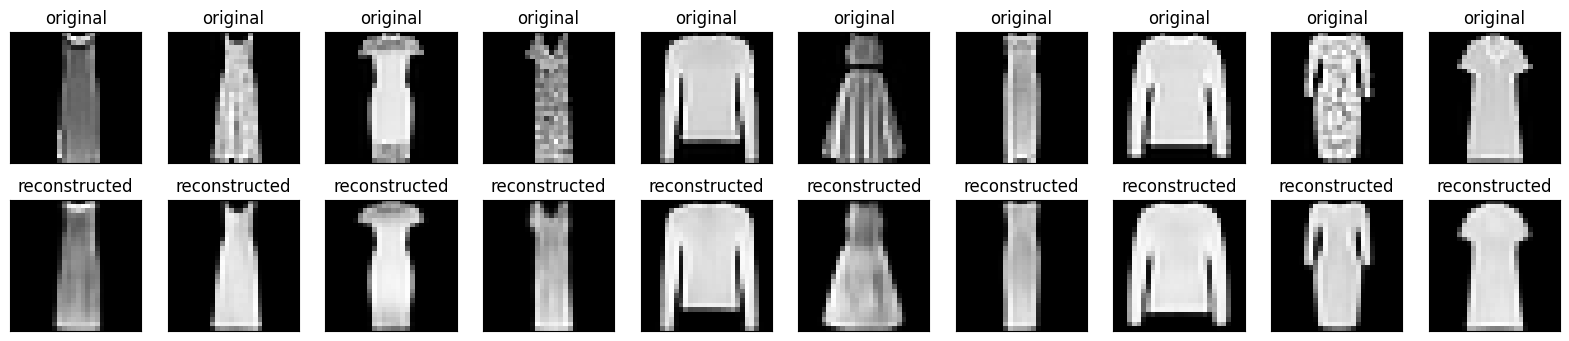

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #menunjukan hasil dari rekonstruksi
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def evaluate_ssim(model, test_data, test_labels):
  ssim_scores = []
  for image, _ in zip(test_data, test_labels):
    reconstructed_image = model.predict(image.reshape((1, 28, 28, 1)))
    ssim = SSIM()(image.reshape((28, 28)), reconstructed_image.squeeze())
    ssim_scores.append(ssim.numpy())
  return np.mean(ssim_scores)

In [ ]:
def evaluate_ssim(model, test_data, test_labels):
  ssim_scores = []
  for image, _ in zip(test_data, test_labels):
    reconstructed_image = model.predict(image.reshape((1, 28, 28, 1)))
    ssim = SSIM()(image.reshape((28, 28)), reconstructed_image.squeeze())
    ssim_scores.append(ssim.numpy())
  return np.mean(ssim_scores)

# Calculate SSIM
ssim_scores = [ssim(x_test[i].reshape(28, 28), decoded[i].reshape(28, 28)) for i in range(len(x_test))]
average_ssim = np.mean(ssim_scores)

# Calculate MSE
mse_scores = np.mean(np.square(x_test - decoded), axis=(1, 2, 3))
average_mse = np.mean(mse_scores)

# Calculate MAE
mae_scores = np.mean(np.abs(x_test - decoded), axis=(1, 2, 3))
average_mae = np.mean(mae_scores)

print(f"Average SSIM on test set: {average_ssim}")
print(f"Average MSE on test set: {average_mse}")
print(f"Average MAE on test set: {average_mae}")

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Average SSIM on test set: 0.8726975882816065
Average MSE on test set: 0.00558584496002537
Average MAE on test set: 0.036220473394448664


In [ ]:
from tensorflow.keras import layers, models, Input

#modifikasi model encoder
input_layer2 = Input(shape=(28, 28, 1))  #-> 784
encode2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer2)
encode2 = layers.MaxPooling2D((2, 2), padding='same')(encode2)
encode2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encode2)
encode2 = layers.MaxPooling2D((2, 2), padding='same')(encode2)
encode2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encode2)
encode2 = layers.Flatten()(encode2)
encoder_output2 = layers.Dense(128, activation='relu')(encode2)  #melakukan reduksi dimensi menjadi 128
encoder2 = models.Model(input_layer2, encoder_output2, name="encoder2")

#modifikasi model decoder
decoder_input2 = layers.Input(shape=(128,))
decode2 = layers.Dense(7 * 7 * 128, activation='relu')(decoder_input2)
decode2 = layers.Reshape((7, 7, 128))(decode2)
decode2 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(decode2)
decode2 = layers.UpSampling2D((2, 2))(decode2)
decode2 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(decode2)
decode2 = layers.Dropout(0.2)(decode2)
decode2 = layers.UpSampling2D((2, 2))(decode2)

#adjust layer final Conv2DTranspose agar sesuai dengan input
decoder_output2 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decode2)
decoder2 = models.Model(decoder_input2, decoder_output2, name="decoder2")

autoencoder_input2 = input_layer2
encoded_img2 = encoder2(autoencoder_input2)
decoded_img2 = decoder2(encoded_img2)
autoencoder2 = models.Model(autoencoder_input2, decoded_img2, name="autoencoder2")

#compile model 2
autoencoder2.compile(loss='mean_squared_error', optimizer='adam')
encoder2.summary()
decoder2.summary()
autoencoder2.summary()

Model: "encoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 128)         738

In [ ]:
#model 2 fitting
history2 = autoencoder2.fit(x_train, x_train, epochs=20, batch_size=64, shuffle=True, validation_data=(x_val, x_val))

Epoch 1/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 2/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 3/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 4/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 5/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 6/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 7/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 8/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/20
175/175 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 10/20
175/175 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0048

In [ ]:
#prediksi model 2
decoded2 = autoencoder2.predict(x_test)

44/44 [==============================] - 0s 2ms/step


In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tensorflow.image import ssim as tf_ssim

def evaluate_ssim2(model, test_data, test_labels):
    ssim_scores2 = []
    for image, _ in zip(test_data, test_labels):
        reconstructed_image = model.predict(image.reshape((1, 28, 28, 1)))
        ssim = tf_ssim(image.reshape((1, 28, 28, 1)), reconstructed_image, max_val=1.0)
        ssim_scores2.append(ssim.numpy())
    return np.mean(ssim_scores2)

decoded2 = autoencoder2.predict(x_test)

#kalkulasi nilai SSIM
ssim_scores2 = [ssim(x_test[i].reshape(28, 28), decoded2[i].reshape(28, 28)) for i in range(len(x_test))]
average_ssim2 = np.mean(ssim_scores2)

# MSE
mse_scores2 = np.mean(np.square(x_test - decoded2), axis=(1, 2, 3))
average_mse2 = np.mean(mse_scores2)

# MAE
mae_scores2 = np.mean(np.abs(x_test - decoded2), axis=(1, 2, 3))
average_mae2 = np.mean(mae_scores2)

print("Modified Model:")
print(f"Average SSIM on test set: {average_ssim2}")
print(f"Average MSE on test set: {average_mse2}")
print(f"Average MAE on test set: {average_mae2}")


44/44 [==============================] - 0s 2ms/step
Modified Model:
Average SSIM on test set: 0.8904163165448437
Average MSE on test set: 0.004931056784533819
Average MAE on test set: 0.033827619848100864


Kesimpulan:

model 1:

SSIM: 0.8726975882816065

MSE: 0.00558584496002537

MAE: 0.036220473394448664



model 2:

SSIM: 0.8904163165448437

MSE: 0.004931056784533819

MAE: 0.033827619848100864


1. SSIM -> mengukur apakah secara struktural gambar yang dihasilkan mirip dengan yang sebenarnya.
2. MSE -> mengukur rata-rata kuadrat dari nilai piksel dari gambar rekonstruksi dengan yang asli.
3. MAE -> mengukur rata-rata absolut dari nilai piksel dari gambar rekonstruksi dengan yang asli.

-> secara konsisten model 2 menunjukan performa yang lebih baik hal tersebut ditunjukan oleh metrics di atas, di mana secara intensitas gambar dan strukturnya (SSID) memimiliki nilai yang lebih rendah.